# <center><span style='background:yellow'> Participez à la conception d'une voiture autonome</span></center>
# <center><span style='background:yellow'>Exploration et transformation des données</span></center>


### Table of Contents <a class="anchor" id="sommaire"></a>
* [Contexte](#0)
* [Chargement et exploration des images](#1)
* [Préparation des inputs des modèles](#2)
  * [Transformation en 8 catégories](#21)
  * [Sauvegarde des images et des masks transformés](#22)

## Contexte <a class="anchor" id="0"></a>

Le but de ce projet est de **concevoir un premier modèle de segmentation d’images** qui devra s'intégrer dans une chaîne complète du système embarqué. Ce dernier se divise en 4 parties :
  1. Acquisition des images en temps réel
  2. Traitement des images
  3. **Segmentation des images**
  4. Système de décision 

Les données utilisées dans ce projet sont téléchargeables via ces deux liens [1](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+8+-+Participez+%C3%A0+la+conception+d'une+voiture+autonome/P8_Cityscapes_leftImg8bit_trainvaltest.zip), [2](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+8+-+Participez+%C3%A0+la+conception+d'une+voiture+autonome/P8_Cityscapes_gtFine_trainvaltest.zip)

On dispose des images ainsi leurs masques, les masques comportent 32 sous-catégories, mais on a besoin que de 8 catégories principales, on va commencer donc par transformer les sous-catégories en 8 catégories puis on va tester des différents modèles de Deep Learning pour la segmentation des images 

## Chargement et exploration des images<a class="anchor" id="1"></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
pip install pandarallel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pandarallel: filename=pandarallel-1.6.4-py3-none-any.whl size=16678 sha256=7d3e20b80e59867679450d24e50850a1c875e3b07461e7e0552ef9bebf729b4d
  Stored in directory: /root/.cache/pip/wheels/62/1e/e7/f9ee096e5cc02890a6934a5670ff6e45a3400f330605bd8210
Successfully built pandarallel


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from glob import glob
from pandarallel import pandarallel

pandarallel.initialize(progress_bar = True,
                       verbose = 2,
                       nb_workers = 6)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [6]:
# Train
img_train_path = '/content/drive/MyDrive/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/*/*'
mask_train_path = '/content/drive/MyDrive/P8_Cityscapes_gtFine_trainvaltest/gtFine/train/*/*'

# Validation
img_val_path = '/content/drive/MyDrive/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val/*/*'
mask_val_path = '/content/drive/MyDrive/P8_Cityscapes_gtFine_trainvaltest/gtFine/val/*/*'

# Test
img_test_path = '/content/drive/MyDrive/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/test/*/*'
mask_test_path = '/content/drive/MyDrive/P8_Cityscapes_gtFine_trainvaltest/gtFine/test/*/*'

In [7]:
print('Nombre des images d\'entraînement est :',len(glob(img_train_path)))
print('Nombre des images de validation est :',len(glob(img_val_path)))
print('Nombre des images de test est :',len(glob(img_test_path)))

Nombre des images d'entraînement est : 2975
Nombre des images de validation est : 500
Nombre des images de test est : 1525


In [8]:
print('Nombre des élements dans le dossier train est :',len(glob(mask_train_path)))
print('Nombre des élements dans le dossier val est :',len(glob(mask_val_path)))
print('Nombre des élements dans le dossier test est :',len(glob(mask_test_path)))

Nombre des élements dans le dossier train est : 11900
Nombre des élements dans le dossier val est : 2000
Nombre des élements dans le dossier test est : 6100


In [9]:
def mask_path_fct(img_path):
  img_name = img_path.split('/')[-1]
  img_name_pop = img_name.split('_')[:-1]
  mask_name =  '_'.join(img_name_pop) + '_gtFine_labelIds.png'
  mask_path = '/content/drive/MyDrive/P8_Cityscapes_gtFine_trainvaltest/gtFine/' + '/'.join(img_path.split('/')[-3:-1]) + '/' + mask_name
  return mask_path

def data_path_fct(img_path):
  
  data_path = pd.DataFrame([], columns = ('image', 'mask'))
  for image_path in glob(img_path):
    new_mask_path = mask_path_fct(image_path)
    data_path = data_path.append(pd.DataFrame([[image_path, new_mask_path]], columns = ('image', 'mask')))
  return data_path

In [10]:
train_path = data_path_fct(img_train_path)
val_path = data_path_fct(img_val_path)
test_path = data_path_fct(img_test_path)

train_path.head()

image  \
0  /content/drive/MyDrive/P8_Cityscapes_leftImg8b...   
0  /content/drive/MyDrive/P8_Cityscapes_leftImg8b...   
0  /content/drive/MyDrive/P8_Cityscapes_leftImg8b...   
0  /content/drive/MyDrive/P8_Cityscapes_leftImg8b...   
0  /content/drive/MyDrive/P8_Cityscapes_leftImg8b...   

                                                mask  
0  /content/drive/MyDrive/P8_Cityscapes_gtFine_tr...  
0  /content/drive/MyDrive/P8_Cityscapes_gtFine_tr...  
0  /content/drive/MyDrive/P8_Cityscapes_gtFine_tr...  
0  /content/drive/MyDrive/P8_Cityscapes_gtFine_tr...  
0  /content/drive/MyDrive/P8_Cityscapes_gtFine_tr...

In [11]:
from random import shuffle
def display_img_mask(image_path, mask_path, max_show=3):

  shuffl = list(range(len(image_path)))
  shuffle(shuffl)
  
  image_path = image_path[shuffl]
  mask_path = mask_path[shuffl]

  i = 0
  for im_path, m_path in zip(*(image_path, mask_path)):
    image = cv2.imread(im_path)
    mask = cv2.imread(m_path)
    fig = plt.figure(figsize=(8,3))
    ax0 = fig.add_subplot(121)
    ax0.imshow(image)
    ax1 = fig.add_subplot(122)
    ax1.imshow(mask*10)
    plt.show()
    i += 1
    if i >= max_show:
      break

Images and masks train :


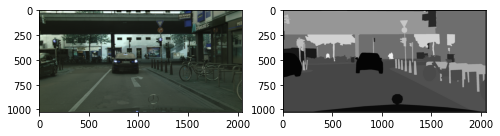

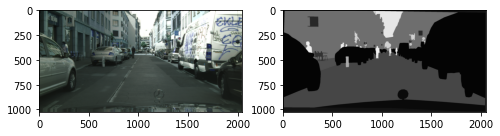

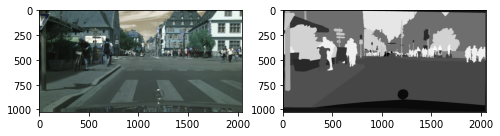

In [12]:
print('Images and masks train :')
display_img_mask(train_path['image'].values, train_path['mask'].values)

Images and masks validation :


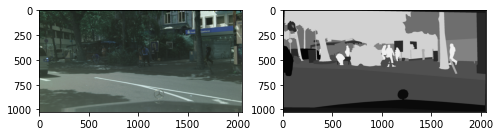

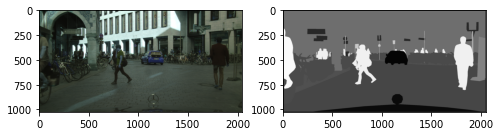

In [13]:
print('Images and masks validation :')
display_img_mask(val_path['image'].values, val_path['mask'].values)

Images and masks test :


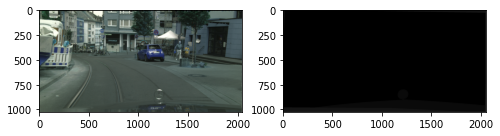

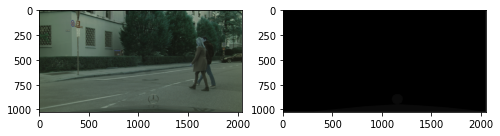

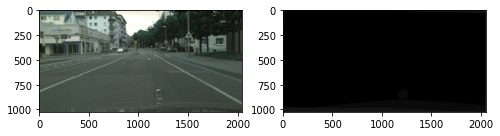

In [14]:
print('Images and masks test :')
display_img_mask(test_path['image'].values, test_path['mask'].values)

In [15]:
from sklearn.model_selection import train_test_split

val_test_path = val_path
del val_path, test_path
val_path, test_path = train_test_split(val_test_path, test_size=150)

In [16]:
print('Images train shape : ', train_path.shape)
print('Images validation  shape : ', val_path.shape)
print('Images test shape : ', test_path.shape)

Images train shape :  (2975, 2)
Images validation  shape :  (350, 2)
Images test shape :  (150, 2)


In [17]:
image0 = cv2.imread(train_path.iloc[0,0])
mask0 = cv2.imread(train_path.iloc[0,1])

print('Image dim :', image0.shape)
print('Mask dim :', mask0.shape)

Image dim : (1024, 2048, 3)
Mask dim : (1024, 2048, 3)


In [18]:
# Sauvegarde des noms des images sous forme des dataframes

paths = '/content/drive/MyDrive/data/'

train_path.to_pickle(paths + 'train_path.pkl')
val_path.to_pickle(paths + 'val_path.pkl')
test_path.to_pickle(paths + 'test_path.pkl')

## Préparation des inputs des modèles<a class="anchor" id="2"></a>

### Transformation en 8 catégories <a class="anchor" id="21"></a>

**Les 8 groupes**
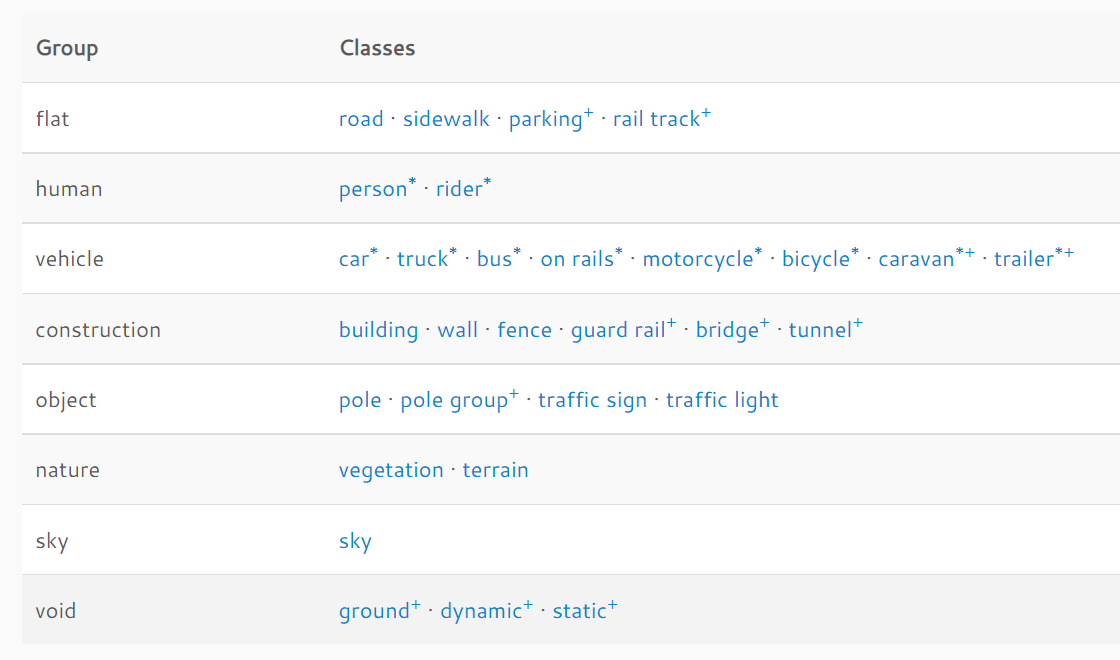

In [19]:
import warnings
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

warnings.filterwarnings('ignore')

cats = {'void': [0, 1, 2, 3, 4, 5, 6],
 'flat': [7, 8, 9, 10],
 'construction': [11, 12, 13, 14, 15, 16],
 'object': [17, 18, 19, 20],
 'nature': [21, 22],
 'sky': [23],
 'human': [24, 25],
 'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]}

def transform_mask(path):
  mask = img_to_array(load_img(path, target_size = (128,256), grayscale = True))
  mask = np.squeeze(mask)
  mask_transformed = np.zeros((mask.shape[0], mask.shape[1],8), dtype='uint8')
  for k in range(8):
    etiq_cat = cats[list(cats.keys())[k]]
        
    for j in etiq_cat:
      mask_transformed[:,:,k] = mask_transformed[:,:,k] | (mask==j) 
            
  return mask_transformed   

In [20]:
transform_mask(train_path.iloc[0,1]).shape

(128, 256, 8)

In [21]:
xtrain = train_path.image.parallel_apply(lambda x: img_to_array(load_img(x, target_size = (128,256,3))))
xval = val_path.image.parallel_apply(lambda x: img_to_array(load_img(x, target_size = (128,256,3))))
xtest = test_path.image.parallel_apply(lambda x: img_to_array(load_img(x, target_size = (128,256,3))))

In [22]:
ytrain = train_path['mask'].parallel_apply(lambda x: transform_mask(x))
yval = val_path['mask'].parallel_apply(lambda x: transform_mask(x))
ytest = test_path['mask'].parallel_apply(lambda x: transform_mask(x))

### Sauvegarde des images et des masks transformés<a class="anchor" id="22"></a>

In [23]:
data_path = "/content/drive/MyDrive/data/"

In [24]:
x_train = np.reshape(xtrain.to_list(), (len(xtrain.to_list()), 128,256,3))
x_val = np.reshape(xval.to_list(), (len(xval.to_list()), 128,256,3))
x_test = np.reshape(xtest.to_list(), (len(xtest.to_list()), 128,256,3))

y_train = np.reshape(ytrain.to_list(), (len(ytrain.to_list()), 128,256,8))
y_val = np.reshape(yval.to_list(), (len(yval.to_list()), 128,256,8))
y_test = np.reshape(ytest.to_list(), (len(ytest.to_list()), 128,256,8))

np.save(data_path + 'x_train',x_train)
np.save(data_path + 'x_val',x_val)
np.save(data_path + 'x_test',x_test)
np.save(data_path + 'y_train',y_train)
np.save(data_path + 'y_val',y_val)
np.save(data_path + 'y_test',y_test)